## Binary Classification with a Software Defects Dataset

Goal: Predict defects in C programs given various attributes about the code.

test.csv - the test dataset; your objective is to predict the probability of positive defects (i.e., defects=True)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## 1. Data Wrangling

In [2]:
# read data
df = pd.read_csv('train.csv')

In [3]:
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
loc,22.0,14.0,11.0,8.0,11.0
v(g),3.0,2.0,2.0,1.0,2.0
ev(g),1.0,1.0,1.0,1.0,1.0
iv(g),2.0,2.0,2.0,1.0,2.0
n,60.0,32.0,45.0,23.0,17.0
v,278.63,151.27,197.65,94.01,60.94
l,0.06,0.14,0.11,0.19,0.18
d,19.56,7.0,8.05,5.25,5.63
i,14.25,21.11,22.76,17.86,12.44


In [4]:
df.nunique()

id                   101763
loc                     378
v(g)                    106
ev(g)                    71
iv(g)                    84
n                       836
v                      4515
l                        55
d                      3360
i                      5171
e                      8729
b                       315
t                      8608
lOCode                  298
lOComment                91
lOBlank                  94
locCodeAndComment        29
uniq_Op                  70
uniq_Opnd               176
total_Op                623
total_Opnd              485
branchCount             144
defects                   2
dtype: int64

In [5]:
df = df.set_index('id')

In [6]:
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [7]:
df.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [8]:
sum(df.duplicated())

0

## 2. Exploratory Data Analysis

In [9]:
bool_label = df.defects.value_counts().index

In [10]:
def_count = df.defects.value_counts().values

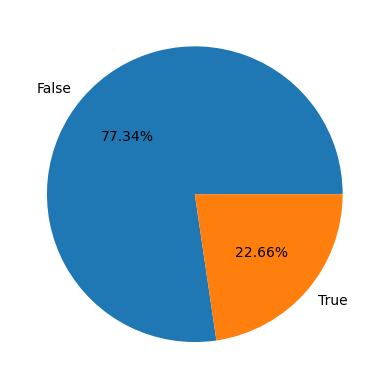

In [11]:
plt.pie(def_count, labels=bool_label, autopct='%1.2f%%')
plt.show()

Only about 20% of the whole dataset are with defects, majority of the code are seemingly ok.

In [13]:
numerical = ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']

In [14]:
#  Get average of count of each variable over the defects they present
avg_distribution = df.groupby('defects')[numerical].mean()
avg_distribution

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
defects,,,,,,,,,,,,,,,,,,,,,
False,27.219329,4.204463,2.193344,2.762919,72.744635,379.242336,0.125356,11.832374,24.992160,11015.031194,...,609.609253,17.573768,1.117625,3.089074,0.124601,11.244006,13.189901,43.450018,29.440183,7.320728
True,71.905350,9.888354,5.068678,6.009886,178.246358,1080.952670,0.064811,19.992771,36.379374,54424.728002,...,2955.791438,40.643774,4.013441,7.019424,0.442291,14.121315,23.809053,106.006634,72.721731,18.434270


In [15]:
avg_dis_trans = avg_distribution.transpose()
avg_dis_trans

defects,False,True
loc,27.219329,71.905350
v(g),4.204463,9.888354
ev(g),2.193344,5.068678
iv(g),2.762919,6.009886
n,72.744635,178.246358
v,379.242336,1080.952670
l,0.125356,0.064811
d,11.832374,19.992771
i,24.992160,36.379374
e,11015.031194,54424.728002


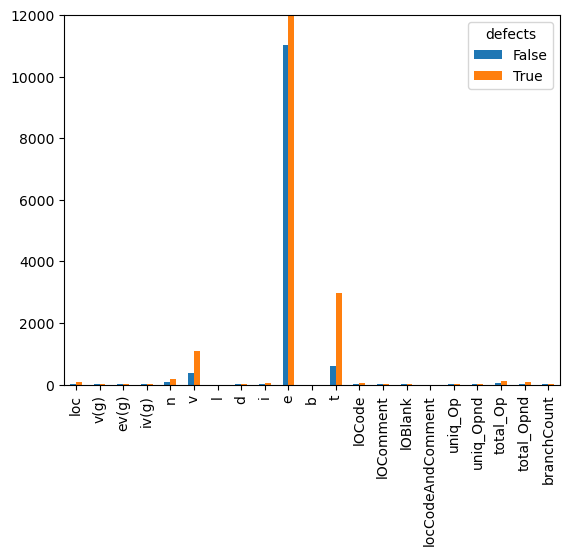

<Figure size 2200x1200 with 0 Axes>

In [16]:
avg_dis_trans.plot(kind='bar')
plt.ylim(0, 12000)
plt.figure(figsize=(22, 12))
plt.show()

e has a significantly higher value range making it impossible to view the other features, a log transformation will be carried out to zoom into the plot.

In [17]:
# log transformation
avg_log = np.log1p(avg_dis_trans)

<Figure size 2000x1200 with 0 Axes>

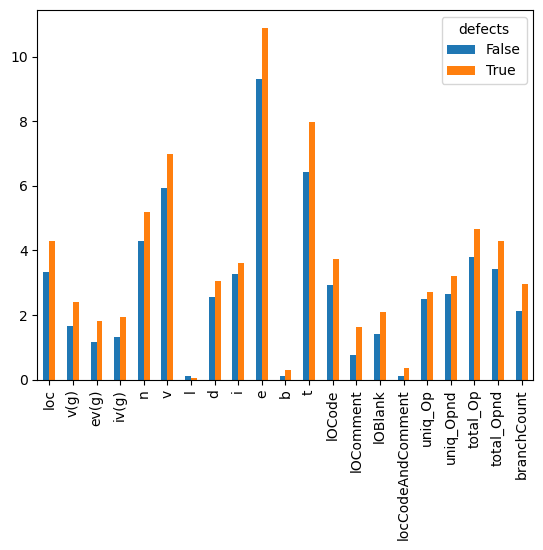

<Figure size 2000x1200 with 0 Axes>

In [18]:
avg_log.plot(kind='bar')
# plt.ylim(0, 12000)
plt.figure(figsize=(20, 12))

General overview shows the higher the values of the variables, these lead to defects.
- e and t have significantly higher mean value ranges in comparison to other features.
- The lower the values of the features, the less likelihood of resulting defects.

#### Feature Importance: Correlation
Corelation between numerical variables and defect.

In [16]:
df_corr = df[numerical].corrwith(df.defects).to_frame('correlation').abs().sort_values(by = 'correlation', ascending=False)
# df_corr.sort_values(by = 'correlation', ascending=False)

In [17]:
df_corr

,correlation
loc,0.342642
branchCount,0.322827
v(g),0.301187
ev(g),0.259928
n,0.258080
lOBlank,0.257819
l,0.253237
total_Opnd,0.252752
lOCode,0.250604
total_Op,0.250533


In [18]:
df_corr.index

Index(['loc', 'branchCount', 'v(g)', 'ev(g)', 'n', 'lOBlank', 'l',
       'total_Opnd', 'lOCode', 'total_Op', 'uniq_Opnd', 'iv(g)', 'd', 'b', 'v',
       'i', 'lOComment', 'uniq_Op', 'locCodeAndComment', 't', 'e'],
      dtype='object')

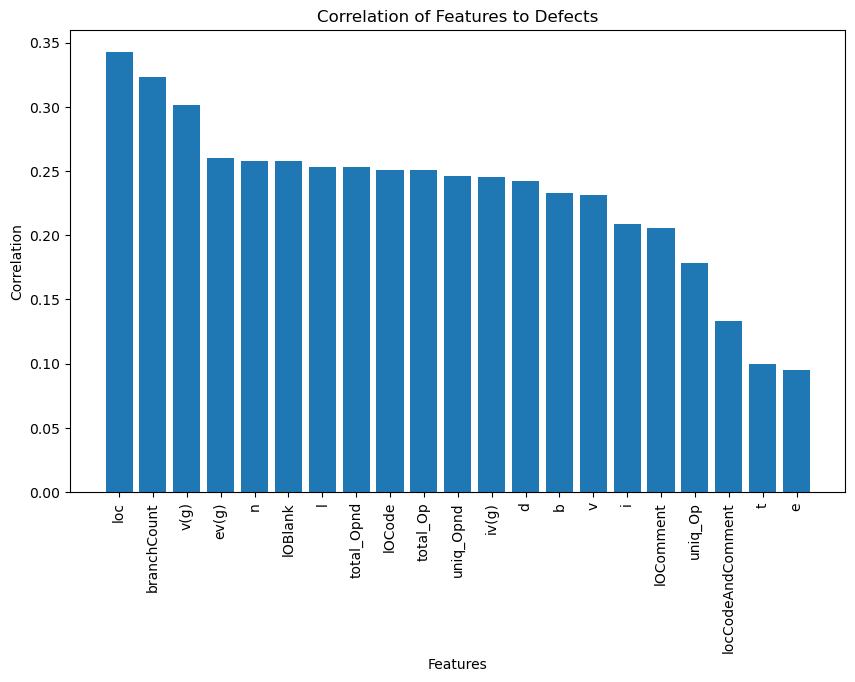

In [19]:
plt.figure(figsize=[10, 6])
plt.bar(df_corr.index, df_corr.correlation)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation of Features to Defects')
plt.show()

The attribute 'loc' appears to have the highest impact on defects in the Programs.
- Despite having high mean values, e and t have the least correlation with defects.

In [20]:
# removing bottom 3 features
# numerical = ['loc', 'branchCount', 'v(g)', 'ev(g)', 'n', 'lOBlank', 'l',
#        'total_Opnd', 'lOCode', 'total_Op', 'uniq_Opnd', 'iv(g)', 'd', 'b', 'v',
#        'i', 'lOComment', 'uniq_Op']

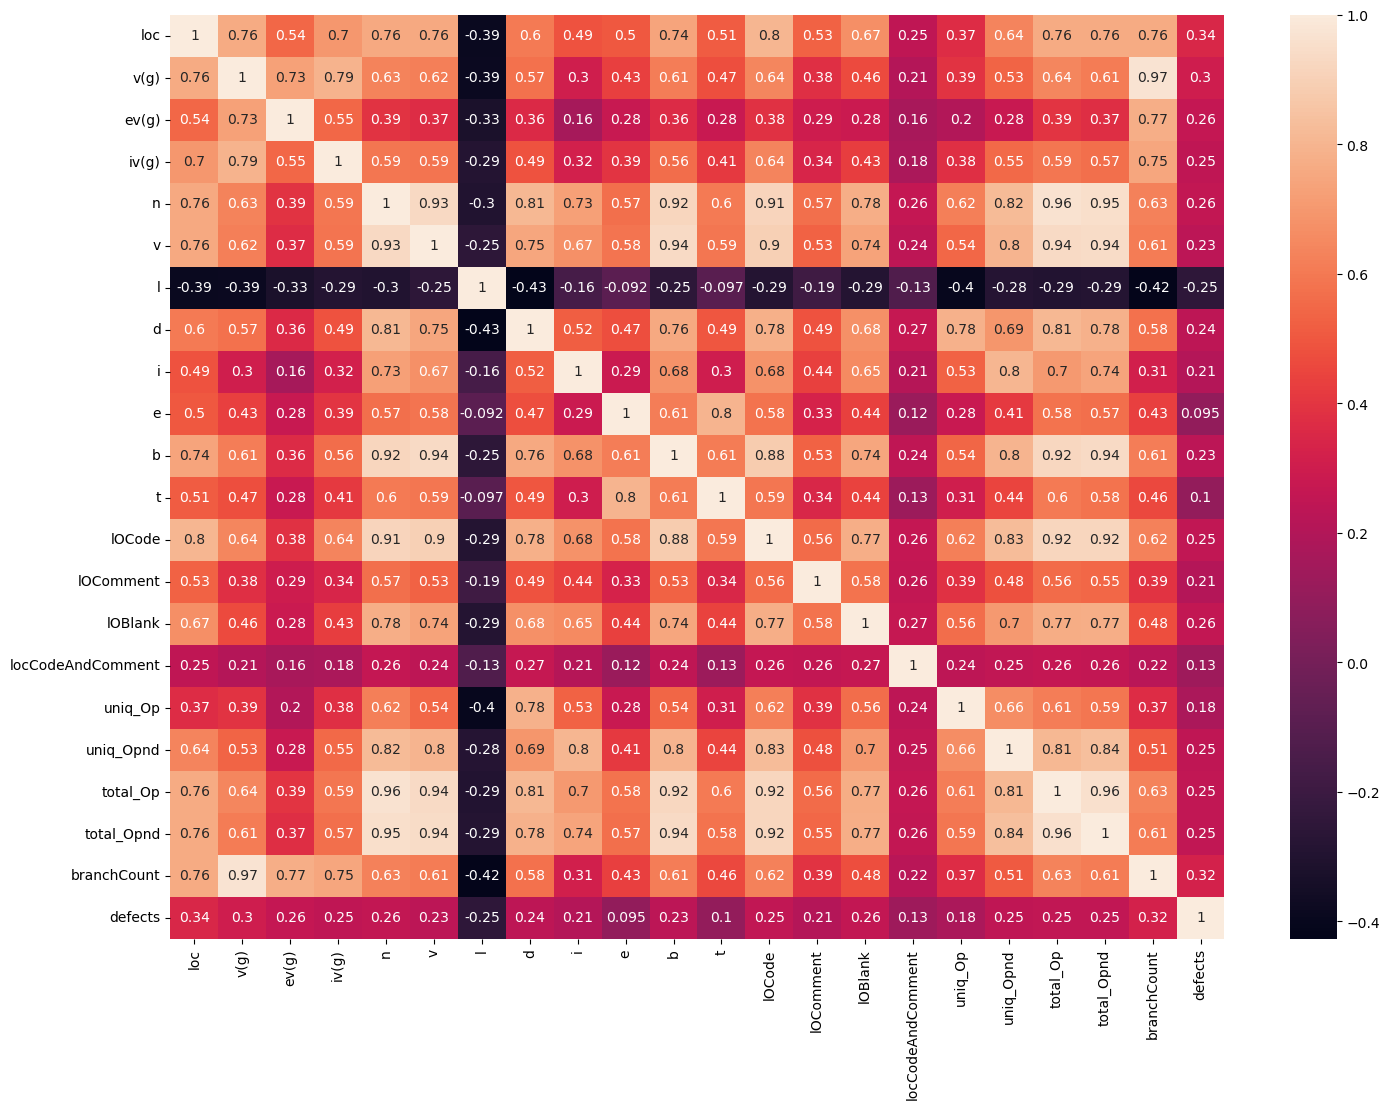

In [21]:
plt.figure(figsize=(17,12))
sns.heatmap(df.corr(), annot=True)
plt.draw()

- High correlation betwen e and t
- IOCCodeandcomment also presents low correlation

In [23]:
# sns.pairplot(df[numerical])

#### Set target variables 

In [24]:
# convert target variable to binary
df['defects'] = df['defects'].astype(int)

In [25]:
# split dataset to train,test and validation
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

len(df_train), len(df_test), len(df_val)

(61057, 20353, 20353)

In [26]:
y_train = df_train.defects.values
y_val = df_val.defects.values
y_test = df_test.defects.values
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# delete target variable from dataset
del df_train['defects']
del df_test['defects']
del df_val['defects']

## 3. Linear Regression method

In [28]:
# Define function to transform dataset to matrix
dv = DictVectorizer(sparse=False)

def df_transform(df):
    df_dict = df[numerical].to_dict(orient='records')
    X_set = dv.fit_transform(df_dict)
    return X_set

In [29]:
X_train = df_transform(df_train)

In [30]:
# train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [31]:
# transform validation dataset
X_val = df_transform(df_val)

In [32]:
# Make predictions on validation dataset
# Checking probability of defect
y_pred = model.predict_proba(X_val)
y_pred

array([[0.24923355, 0.75076645],
       [0.88990191, 0.11009809],
       [0.77019733, 0.22980267],
       ...,
       [0.88000493, 0.11999507],
       [0.69938773, 0.30061227],
       [0.86621347, 0.13378653]])

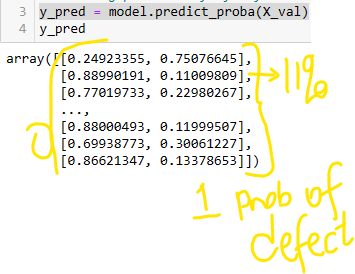

- Because we only want the probability of defect arising, ie defect = 1/True, we'll select the second column.

In [33]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.75076645, 0.11009809, 0.22980267, ..., 0.11999507, 0.30061227,
       0.13378653])

In [34]:
# check score
roc_auc_score(y_val, y_pred)

0.7837319755979318

In [35]:
# Make predictions on test dataset
X_test = df_transform(df_test)
y_pred_test = model.predict_proba(X_test)[:, 1]

In [36]:
# Check score
roc_auc_score(y_test, y_pred_test)

0.7812615539368333

The accuracy reduces when we try predicting with the test data, we'll try to fine tune more with other methods

## 4 Decision Tree method

In [37]:
dv.get_feature_names_out()

array(['b', 'branchCount', 'd', 'e', 'ev(g)', 'i', 'iv(g)', 'l',
       'lOBlank', 'lOCode', 'lOComment', 'loc', 'locCodeAndComment', 'n',
       't', 'total_Op', 'total_Opnd', 'uniq_Op', 'uniq_Opnd', 'v', 'v(g)'],
      dtype=object)

In [38]:
# Train decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
y_pred = dt.predict_proba(X_val)[:, 1]
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
# check score
roc_auc_score(y_val, y_pred)

0.6143627726266077

In [41]:
# make prediction with test data
y_pred = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.604197147992899

In [42]:
# Check on training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Scoring a 1 on the train dataset tells us we have a case of overfitting. 
The Decision tree method seems to have a much more lower accuracy than the regression method, however we can perform some fine tuning on the Decision tree to see how the model can be improved.

### 4.1 Decision Trees Parameter Tuning
#### 4.1.1 Adjusting max_depth parameter

In [43]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 22, 25, 30, 40, 60, None]

In [44]:
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.4f' % (d, auc))

   1 -> 0.7135
   2 -> 0.7631
   3 -> 0.7818
   4 -> 0.7853
   5 -> 0.7884
   6 -> 0.7884
   7 -> 0.7866
   8 -> 0.7817
  10 -> 0.7648
  12 -> 0.7386
  15 -> 0.6907
  20 -> 0.6170
  22 -> 0.6043
  25 -> 0.5997
  30 -> 0.6002
  40 -> 0.6143
  60 -> 0.6171
None -> 0.6165


In [45]:
# Check on test dataset
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    print('%4s -> %.4f' % (d, auc))

   1 -> 0.7019
   2 -> 0.7613
   3 -> 0.7811
   4 -> 0.7841
   5 -> 0.7863
   6 -> 0.7861
   7 -> 0.7828
   8 -> 0.7774
  10 -> 0.7612
  12 -> 0.7311
  15 -> 0.6851
  20 -> 0.6136
  22 -> 0.5965
  25 -> 0.5913
  30 -> 0.5915
  40 -> 0.6051
  60 -> 0.6080
None -> 0.6072


I'll select the top 4 performers in this case, 4, 5, 6, and 7.

#### 4.2 Adjusting min_samples_leaf for selelcted max_depth values

In [46]:
scores = []

for d in [4, 5, 6, 7]:
    for s in [1, 2, 5, 10, 15, 20 , 30, 50, 100, 200, 400, 600]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, s, auc))

In [47]:
columns=['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
45,7,200,0.790046
33,6,200,0.789688
32,6,100,0.789260
34,6,400,0.789201
46,7,400,0.789156
31,6,50,0.789149
47,7,600,0.788896
29,6,20,0.788872
30,6,30,0.788866
27,6,10,0.788761


In [48]:
# pivot df
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'],
                                 values=['auc'])
df_scores_pivot.round(3)

auc                     
max_depth             4      5      6      7
min_samples_leaf                            
1                 0.785  0.788  0.788  0.787
2                 0.785  0.788  0.788  0.786
5                 0.785  0.788  0.789  0.787
10                0.785  0.788  0.789  0.788
15                0.785  0.788  0.789  0.788
20                0.785  0.788  0.789  0.787
30                0.785  0.788  0.789  0.788
50                0.785  0.788  0.789  0.788
100               0.785  0.788  0.789  0.788
200               0.785  0.788  0.790  0.790
400               0.785  0.788  0.789  0.789
600               0.785  0.788  0.788  0.789

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

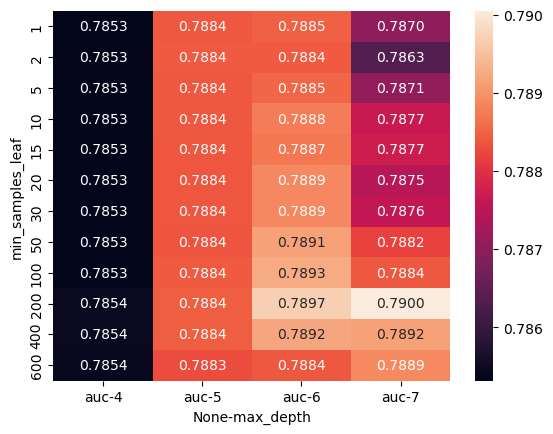

In [49]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.4f')

The best auc score is gotten from:
- max_depth=7 
- min_sample_leaf=200

In [50]:
# Retry model with above parameters
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=200)
dt.fit(X_train, y_train)
    
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.7900464220847041

Note significant increase from 0.6 - 0.8. 

In [51]:
# Try on test data
y_pred = dt.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.7864636286711548

The model performs slightly lower with the test data. I'll proceed to the next method, Random Forest.

## 5. Random Forest Method

In [52]:
# create random forest model
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [53]:
# Make prediction on validation dataset
y_pred = rf.predict_proba(X_val)[:, 1]
y_pred

array([0.4, 0. , 0.3, ..., 0. , 0.4, 0.3])

In [54]:
roc_auc_score(y_val, y_pred)

0.7449839056170755

In [55]:
# check on test dataset
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.7391552174411757

### 5.1 Fine Tuning RF model

#### 5.1.1 Increasing estimators

In [56]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [57]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.744984
1,20,0.762747
2,30,0.769528
3,40,0.773077
4,50,0.774581
5,60,0.776054
6,70,0.776550
7,80,0.776791
8,90,0.777192
9,100,0.777596


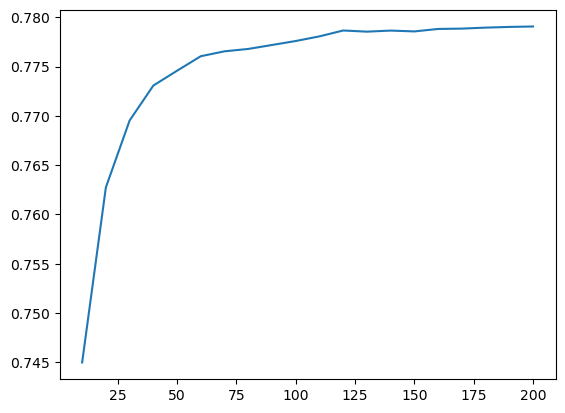

In [58]:
plt.plot(df_scores.n_estimators, df_scores.auc)

#### 5.1.2 Training models with varying max depth parameter

In [59]:
from tqdm.auto import tqdm

In [60]:
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []
    for d in [5, 10, 15]:
        for n in range(10, 201, 10):
            rf = RandomForestClassifier(n_estimators=n,
                                        max_depth = d,
                                        random_state=1,
                                       n_jobs = -1)
            rf.fit(X_train, y_train)

            y_pred = rf.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append((d, n, auc))

  0%|          | 0/7 [00:00<?, ?it/s]

In [61]:
columns=['max_depth' ,'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787391
1,5,20,0.787491
2,5,30,0.787973
3,5,40,0.787910
4,5,50,0.787895


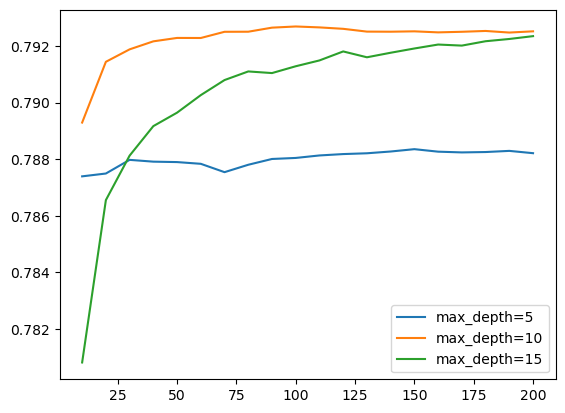

In [62]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,
            label='max_depth=%d'% d)
    
plt.legend()

Max depth of 10 presents the best score.

#### 5.1.3 Optimizing model with min_samples_leaf parameter

In [63]:
max_depth = 10

In [64]:
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    for s in [1, 3, 5, 10, 15]:
        for n in range(10, 201, 10):
            rf = RandomForestClassifier(n_estimators=n,
                                       max_depth = max_depth,
                                       min_samples_leaf=s,
                                       random_state=1,
                                       n_jobs=-1)
            rf.fit(X_train, y_train)
            y_pred = rf.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append((s, n, auc))        

  0%|          | 0/7 [00:00<?, ?it/s]

In [65]:
columns=['min_samples_leaf' ,'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.789291
1,1,20,0.791439
2,1,30,0.791879
3,1,40,0.792162
4,1,50,0.792283


In [66]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 15]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (15, 'grey')]

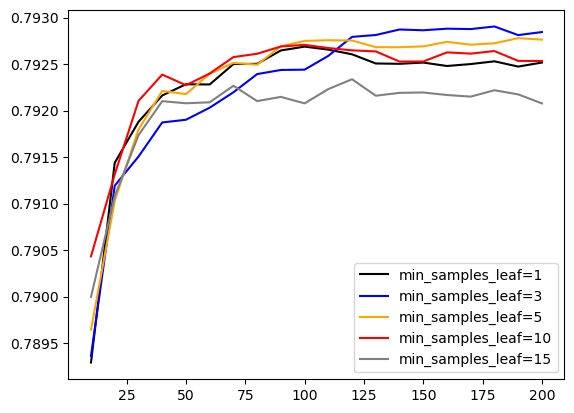

In [70]:
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color = col,
            label='min_samples_leaf=%d'% s)
    
plt.legend()

min_samples_leaf = 3, learns slowly but attains a good steady score. 
Therefore the parameters from this method will be:
- max_depth = 10
- min_samples_leaf = 3
- 175 iterations

## 6. Gradient Boosting Method
With Gradient boosting method, the sequence for tuning would be:
- Eta parameters
- Max_depth - where max_depth = 6 by default
- min_child_weight

In [74]:
# Get feature names transform train and val matrix
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

A watchlist will be created to contain the datasets with which the model will be evaluated, taking in a list of tuples.

In [73]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
# watchlist = [(dtrain, 'train'), (dval, 'val'), (dtest, 'test')]

In [75]:
# function to capture the output, split and convert every line
def parse_xgb_output(ouput):
    results=[]
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))

#   Turn into a dataframe
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [99]:
%%capture output

# Set parameters for binary classification model
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight':1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

# create model
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                 evals=watchlist)

In [100]:
df_score = parse_xgb_output(output)
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.79069,0.78781
1,5,0.79579,0.79199
2,10,0.79770,0.79188
3,15,0.79992,0.79249
4,20,0.80238,0.79268


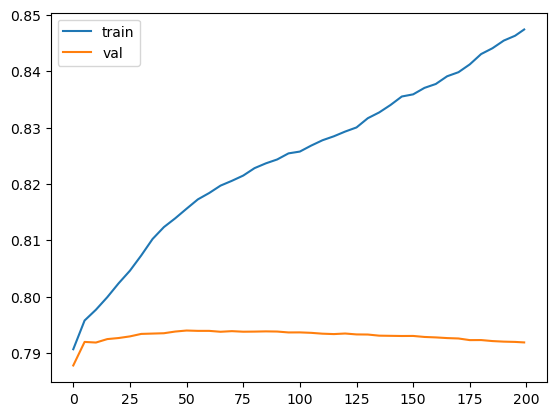

In [101]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

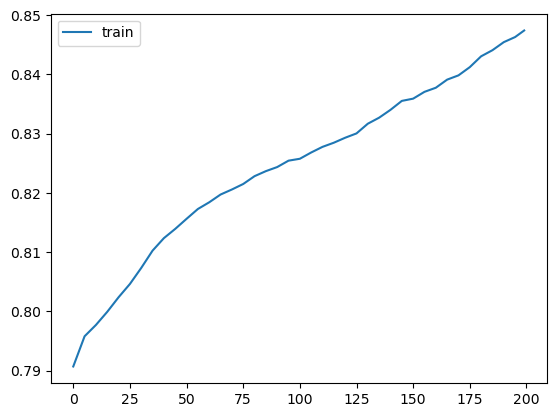

In [102]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
# plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

Following the plot above, it'll be necessary to carry out some parameters tuning, as the shape doesn't correspond close to what an ideal train model should look like. 
First parameter I'll be tuning would be eta = [1.0, 0.3, 0.1, 0.05, 0.01] 

In [113]:
# reset scores
scores = {}

In [122]:
%%capture output

# Set parameters for binary classification model
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight':1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

# create model
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                 evals=watchlist)

In [123]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

Rerun above line, changing eta from 1.0 - 0.01, after that run below line to check eta values used and proceed to plotting.

In [124]:
scores.keys()

dict_keys(['eta=1.0', 'eta=0.3', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

#### Plot XGBoost Evaluation scores with varying eta values

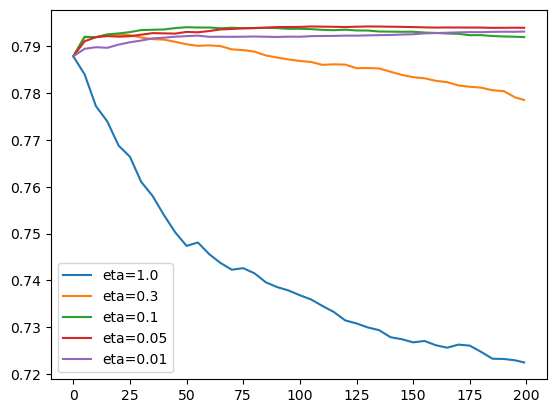

In [126]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
# plt.plot(df_score.num_iter, df_score.val_auc, label='val')
    plt.legend()

eta = 1.0 and 0.3 seem to drop, replot graph without them.

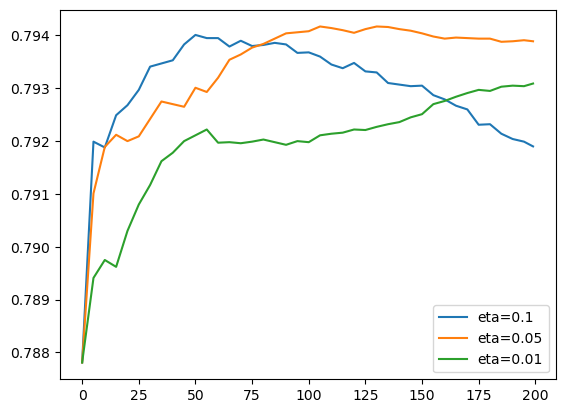

In [128]:
etas = ['eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

Selection from this would be 0.05

### Tuning Max_depth paramter 
- making use of 0.05 as the best eta
- test out max_depth parameter = [1, 2, 3, 4, 6, 10]

In [160]:
# reset scores
scores = {}

In [173]:
%%capture output

# Set parameters for binary classification model
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'min_child_weight':1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

# create model
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                 evals=watchlist)

In [174]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [175]:
scores.keys()

dict_keys(['max_depth=1', 'max_depth=2', 'max_depth=3', 'max_depth=4', 'max_depth=6', 'max_depth=8', 'max_depth=10'])

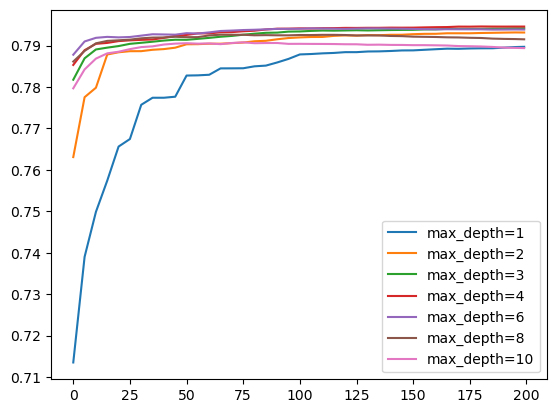

In [176]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

delete depths 1, 2, 10, 8

In [184]:
del scores['max_depth=8']

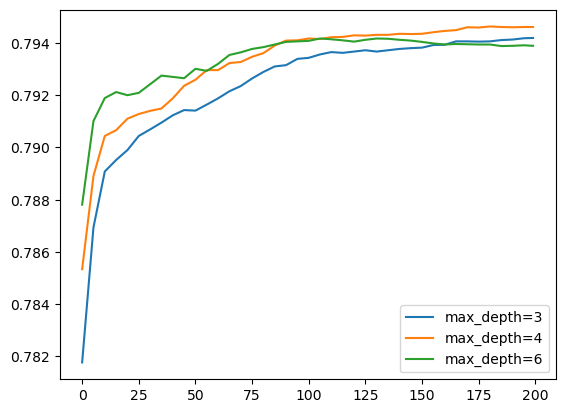

In [185]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

max_depth = 4, has the best performance.

### Turning child weight for decision tree
- making use of the following confirmed parameters:
    - eta = 0.05
    - max_depth = 4
    - min_child_weight = [1, 10, 20, 30]

In [186]:
# reset scores
scores = {}

In [194]:
%%capture output

# Set parameters for binary classification model
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight':30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

# create model
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                 evals=watchlist)

In [195]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [196]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=20', 'min_child_weight=30'])

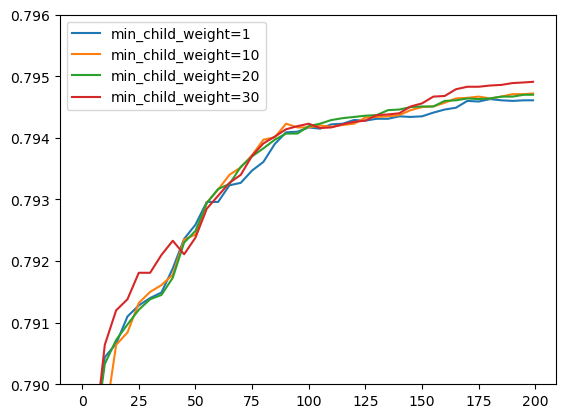

In [201]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.79, 0.796)    
plt.legend()

Train on 30 and 160 iteration

## 7. Selecting the Best and Final model

### 7.1 Train decision tree model with our best deicision tree parameters
- max_depth = 7
- min_sapmples_leaf = 200

In [203]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=200)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=200)

### 7.2 Train model with Best Random forest
- max_depth = 10
- min_samples_leaf = 3

In [204]:
rf = RandomForestClassifier(n_estimators=n, max_depth = 10,
                            min_samples_leaf=3, random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1, random_state=1)

### 7.3 Train mode with XGBoost model

In [205]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight':30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

# create model
model = xgb.train(xgb_params, dtrain, num_boost_round=160)

### 7.4 Comparing Models for best performance on validation

In [206]:
# Decision tree score
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7900464220847041

In [207]:
# Random forest score
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7928443318983793

In [208]:
# xgb score
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.7946775729565345

## 8. Training Final Model with full dataset

In [210]:
df_train_full.reset_index(drop=True)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,12.0,4.0,4.0,1.0,38.0,166.91,0.12,8.25,20.01,1468.79,...,9,0,1,0,11.0,8.0,26.0,12.0,7.0,0
1,13.0,2.0,1.0,2.0,36.0,158.12,0.16,6.22,22.12,919.01,...,9,0,2,0,7.0,9.0,21.0,15.0,3.0,0
2,20.0,3.0,1.0,3.0,55.0,250.00,0.13,8.00,32.70,1976.54,...,15,0,3,1,10.0,13.0,33.0,22.0,5.0,0
3,25.0,5.0,1.0,3.0,78.0,357.78,0.05,20.00,18.92,6186.03,...,21,0,2,0,13.0,9.0,46.0,32.0,9.0,0
4,50.0,8.0,1.0,7.0,185.0,1043.45,0.05,21.77,45.83,22176.04,...,35,0,9,0,18.0,31.0,120.0,73.0,15.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81405,20.0,8.0,4.0,4.0,207.0,1116.21,0.03,34.00,32.83,37951.13,...,11,3,8,0,24.0,18.0,156.0,51.0,15.0,0
81406,21.0,3.0,1.0,3.0,81.0,403.21,0.20,4.90,78.85,1969.97,...,17,0,3,0,7.0,25.0,44.0,37.0,5.0,1
81407,17.0,2.0,1.0,1.0,39.0,181.11,0.08,12.00,14.34,2148.39,...,9,0,2,0,16.0,8.0,25.0,14.0,3.0,0
81408,26.0,9.0,7.0,4.0,97.0,485.00,0.04,26.67,19.47,14346.93,...,23,0,1,0,20.0,15.0,56.0,41.0,17.0,0


In [211]:
# Get target variable on full dataframe (already converted)
y_full_train = (df_train_full.defects).values
y_full_train

array([0, 0, 0, ..., 0, 0, 0])

In [212]:
# delete target from table
del df_train_full['defects']

### 8.1 Create feature matrices for train and test 

In [213]:
# Get dictionaries 
dicts_full_train = df_train_full.to_dict(orient='records')

# turn into vectors/matrix using dictvectorizer
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

# create test matrix
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

### 8.2 Training and Evaluating ML model

In [214]:
# Creating matrix
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                        feature_names=dv.get_feature_names_out())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out())

In [215]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight':30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

# create model
model = xgb.train(xgb_params, dtrain, num_boost_round=160)

In [216]:
y_pred = model.predict(dtest)

In [217]:
y_pred[:10]

array([0.05610298, 0.4304756 , 0.12932372, 0.10351269, 0.44406334,
       0.10317276, 0.06752012, 0.43317568, 0.08656003, 0.11386435],
      dtype=float32)

In [218]:
roc_auc_score(y_test, y_pred)

0.793301826792277